In [77]:
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Process, Queue

In [78]:
class Cliff:
    action_table = {0: np.array([0, 1]), 1: np.array([1, 0]), 2: np.array([0, -1]), 3: np.array([-1, 0])}

    def __init__(self):
        self.pos = (3, 0)
    
    def reset(self):
        self.pos = (3, 0)
        return self.pos
    
    def step(self, action):
        new_pos = self.pos + self.action_table[action]
        new_pos = np.clip(new_pos, [0, 0], [3, 11])

        reward = -1
        done = False

        if new_pos[0] == 3 and 1 <= new_pos[1] <= 10:
            reward = -100
            new_pos = np.array([3, 0])
        
        if (new_pos == [3, 11]).all():
            done = True

        self.pos = tuple(new_pos)

        return self.pos, reward, done

In [79]:
class SARSA:
    def __init__(self, alpha=0.1, epsilon=0.1, gamma=1, episodes=500, do=False):
        self.q_table = np.zeros((4, 12, 4))
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        if do:
            self.do(episodes)

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(4)
        else:
            return np.argmax(self.q_table[state])
        
    def do(self, episodes):
        cliff = Cliff()
        self.total_rewards = []
        for episode in range(episodes):
            state = cliff.reset()
            action = self.select_action(state)
            done = False

            total_reward = 0
            while not done:
                next_state, reward, done = cliff.step(action)
                total_reward += reward
                next_action = self.select_action(next_state)

                self.q_table[state][action] += self.alpha * (reward + self.gamma * self.q_table[next_state][next_action] - self.q_table[state][action])

                state = next_state
                action = next_action

            self.total_rewards.append(total_reward)

In [80]:
class QLearning:
    def __init__(self, alpha=0.1, epsilon=0.1, gamma=1, episodes=500, do=False):
        self.q_table = np.zeros((4, 12, 4))
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        if do:
            self.do(episodes)

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(4)
        else:
            return np.argmax(self.q_table[state])
        
    def do(self, episodes):
        cliff = Cliff()
        self.total_rewards = []

        for episode in range(episodes):
            state = cliff.reset()
            done = False
            
            total_reward = 0
            while not done:
                action = self.select_action(state)
                next_state, reward, done = cliff.step(action)
                total_reward += reward

                self.q_table[state][action] += self.alpha * (reward + self.gamma * np.max(self.q_table[next_state]) - self.q_table[state][action])

                state = next_state

            self.total_rewards.append(total_reward)

In [81]:
class ExpectedSARSA:
    def __init__(self, alpha=0.1, epsilon=0.1, gamma=1, episodes=500, do=False):
        self.q_table = np.zeros((4, 12, 4))
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        if do:
            self.do(episodes)

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(4)
        else:
            return np.argmax(self.q_table[state])
        
    def do(self, episodes):
        cliff = Cliff()
        self.total_rewards = []

        for episode in range(episodes):
            state = cliff.reset()
            done = False

            total_reward = 0
            while not done:
                action = self.select_action(state)
                next_state, reward, done = cliff.step(action)
                total_reward += reward

                next_action = np.argmax(self.q_table[next_state])

                expected_value = 0
                for a in range(4):
                    if a == next_action:
                        expected_value += (1 - self.epsilon + self.epsilon / 4) * self.q_table[next_state][a]
                    else:
                        expected_value += self.epsilon / 4 * self.q_table[next_state][a]

                self.q_table[state][action] += self.alpha * (reward + self.gamma * expected_value - self.q_table[state][action])

                state = next_state

            self.total_rewards.append(total_reward)

In [82]:
alphas = [0.1*i for i in range(1, 11)]

episodes = 10000
samples = 256

In [83]:
q1 = Queue()
q2 = Queue()

In [84]:
def work(alphas, episodes, rd_seed):
    np.random.seed(rd_seed)

    SARSAs = [SARSA(alpha=a, episodes=episodes, do=True) for a in alphas]
    QLearnings = [QLearning(alpha=a, episodes=episodes, do=True) for a in alphas]
    ExpectedSARSAs = [ExpectedSARSA(alpha=a, episodes=episodes, do=True) for a in alphas]

    SARSAs_mids_reward = [s.total_rewards[10] for s in SARSAs]
    QLearnings_mids_reward = [s.total_rewards[10] for s in QLearnings]
    ExpectedSARSAs_mids_reward = [s.total_rewards[10] for s in ExpectedSARSAs]

    SARSAs_ends_reward = [s.total_rewards[-1] for s in SARSAs]
    QLearnings_ends_reward = [s.total_rewards[-1] for s in QLearnings]
    ExpectedSARSAs_ends_reward = [s.total_rewards[-1] for s in ExpectedSARSAs]

    q1.put((SARSAs_mids_reward, QLearnings_mids_reward, ExpectedSARSAs_mids_reward))
    q2.put((SARSAs_ends_reward, QLearnings_ends_reward, ExpectedSARSAs_ends_reward))

In [85]:
th_s = []

for i in range(samples):
    th_s.append(Process(target=work, args=(alphas, episodes, np.random.randint(0, 10000000))))

for th in th_s:
    th.start()

for th in th_s:
    th.join()

In [86]:
SARSAs_mids_rewards = []
QLearnings_mids_rewards = []
ExpectedSARSAs_mids_rewards = []

for i in range(samples):
    SARSAs_mids_reward, QLearnings_mids_reward, ExpectedSARSAs_mids_reward = q1.get()
    SARSAs_mids_rewards.append(SARSAs_mids_reward)
    QLearnings_mids_rewards.append(QLearnings_mids_reward)
    ExpectedSARSAs_mids_rewards.append(ExpectedSARSAs_mids_reward)

In [87]:
SARSAs_ends_rewards = []
QLearnings_ends_rewards = []
ExpectedSARSAs_ends_rewards = []

for i in range(samples):
    SARSAs_ends_reward, QLearnings_ends_reward, ExpectedSARSAs_ends_reward = q2.get()
    SARSAs_ends_rewards.append(SARSAs_ends_reward)
    QLearnings_ends_rewards.append(QLearnings_ends_reward)
    ExpectedSARSAs_ends_rewards.append(ExpectedSARSAs_ends_reward)

In [88]:
SARSAs_mids_rewards = np.array(SARSAs_mids_rewards)
QLearnings_mids_rewards = np.array(QLearnings_mids_rewards)
ExpectedSARSAs_mids_rewards = np.array(ExpectedSARSAs_mids_rewards)

SARSAs_ends_rewards = np.array(SARSAs_ends_rewards)
QLearnings_ends_rewards = np.array(QLearnings_ends_rewards)
ExpectedSARSAs_ends_rewards = np.array(ExpectedSARSAs_ends_rewards)

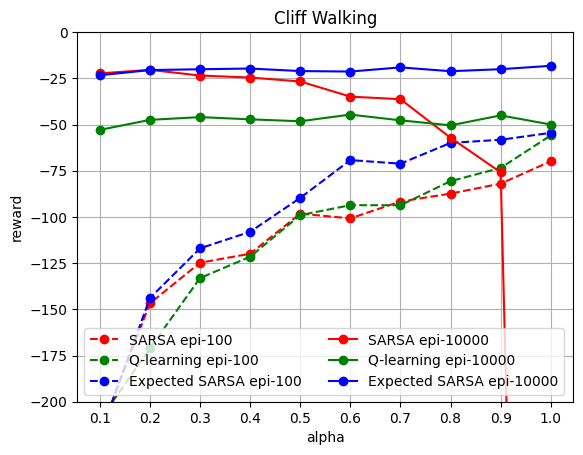

In [94]:
plt.plot(alphas, SARSAs_mids_rewards.mean(axis=0), 'ro--', label='SARSA epi-100')
plt.plot(alphas, QLearnings_mids_rewards.mean(axis=0), 'go--', label='Q-learning epi-100')
plt.plot(alphas, ExpectedSARSAs_mids_rewards.mean(axis=0), 'bo--', label='Expected SARSA epi-100')

plt.plot(alphas, SARSAs_ends_rewards.mean(axis=0), 'ro-', label='SARSA epi-10000')
plt.plot(alphas, QLearnings_ends_rewards.mean(axis=0), 'go-', label='Q-learning epi-10000')
plt.plot(alphas, ExpectedSARSAs_ends_rewards.mean(axis=0), 'bo-', label='Expected SARSA epi-10000')

plt.xticks(alphas)
plt.xlabel('alpha')
plt.ylabel('reward')
plt.title('Cliff Walking')
plt.legend(ncol=2)
plt.ylim(-200, 0)
plt.grid()
plt.show()